In [1]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import base, metrics, model_selection, preprocessing, tree, utils
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
import shap
import xgboost as xgb
import pandas_profiling
import itertools
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

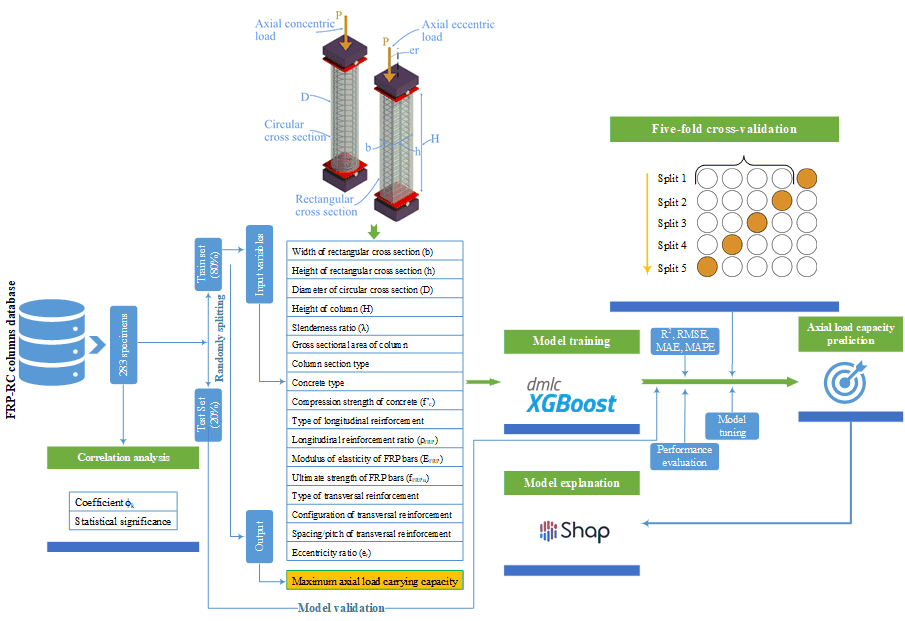

In [2]:
Image(filename='XGBoost prediction.png' )

# 1.0 Import the Data


In [3]:
# Read in the Data
Donnees = pd.read_excel("FRP-RC_Columns_Database.xlsx", usecols="A:AA", header=0)
Donnees.head()

No.      Spec.    b    h  D     H  LamdaC      Ag Circular TypeCon  ...  \
0    1       A-12  610  610  -  3000      17  372100       No     NWC  ...   
1    2       B-12  610  610  -  3000      17  372100       No     NWC  ...   
2    3        A-3  610  610  -  3000      17  372100       No     NWC  ...   
3    4        B-3  610  610  -  3000      17  372100       No     NWC  ...   
4    5  C-G-1-120  350  350  -  1400      14  122500       No     NWC  ...   

   TypeH      Bars.1  Config SpacPitch  EfrpH  ffuH  efuH    e EoverD  \
0   GFRP       No. 4    Ties       305      -     -     -  0.0      0   
1   GFRP       No. 4    Ties       305      -     -     -  0.0      0   
2   GFRP       No. 4    Ties        76      -     -     -  0.0      0   
3   GFRP       No. 4    Ties        76      -     -     -  0.0      0   
4   GFRP  No.13 ties    Ties       120     44   640  1.45  0.0      0   

        Pexp  
0  15235.000  
1  12949.000  
2  11926.000  
3  10751.000  
4   3928.575  

[5 rows x 27 columns]

# 2.0 Convert into Numerical Values


In [4]:
Donnees['LamdaC'] = Donnees['LamdaC'].astype(float)
Donnees['SpacPitch'] = Donnees['SpacPitch'].astype(float)
Donnees['EoverD'] = Donnees['EoverD'].astype(float)
Donnees['ffuL'] = Donnees['ffuL'].astype(float)
Donnees['Ag'] = Donnees['Ag'].astype(float)
Donnees['fcp'] = Donnees['fcp'].astype(float)
Donnees['RhoEf'] = Donnees['RhoEf'].astype(float)
Donnees['Pexp'] = Donnees['Pexp'].astype(float)
Donnees['EfrpL'] = Donnees['EfrpL'].astype(float)

In [5]:
# All the Data
Data= Donnees[[ 'LamdaC','Circular', 'Ag', 'TypeCon', 'fcp', 'TypeL', 'RhoEf', 'EfrpL', 'ffuL', 'TypeH', 'Config', 'SpacPitch','EoverD','Pexp']]

# Data with variable from existing models
DataCode = Data[(Data["EoverD"]==0) & (Data["LamdaC"]<=22)]
DataCode =  DataCode[[ 'Circular', 'Ag', 'fcp', 'RhoEf', 'EfrpL', 'ffuL', 'Pexp']]

# Data without confinement
DataNoConfin= Donnees[['LamdaC','Circular', 'Ag', 'TypeCon', 'fcp', 'TypeL', 'RhoEf', 'EfrpL', 'ffuL', 'EoverD','Pexp']]

# Concentric RC-Columns only
DataConcentric = Data[(Data["EoverD"]==0)]
DataConcentric = DataConcentric.drop('EoverD', axis = 1)

# Eccentric RC-Columns only
DataEccentric =  Data[(Data["EoverD"] > 0)]

# 3.0 Exploratory Data Analysis 

In [6]:
Data.describe()

LamdaC             Ag         fcp       RhoEf       EfrpL  \
count  283.000000     283.000000  283.000000  283.000000  283.000000   
mean    21.621908   75532.261484   44.680000    2.083463   70.640106   
std      7.613106   50424.293536   14.452926    0.872961   35.621739   
min     10.000000   14400.000000   25.600000    0.550000   39.000000   
25%     17.000000   41600.000000   35.000000    1.400000   50.000000   
50%     20.000000   73062.000000   42.300000    2.180000   55.400000   
75%     21.000000   73062.000000   52.000000    2.220000   62.700000   
max     62.000000  372100.000000   90.000000    4.800000  151.000000   

              ffuL   SpacPitch      EoverD          Pexp  
count   283.000000  283.000000  283.000000    283.000000  
mean   1248.183746  100.063604   20.420495   2019.014558  
std     390.870253   51.252983   25.289877   1867.339592  
min     574.000000   30.000000    0.000000     90.000000  
25%     930.000000   80.000000    0.000000    789.900000  
50%    1289.000000   80.000000   12.000000   1483.000000  
75%    1449.000000  120.000000   33.000000   2962.000000  
max    2000.000000  305.000000  100.000000  15235.000000

In [7]:
DataCode.describe()

Ag        fcp      RhoEf       EfrpL         ffuL  \
count      94.000000  94.000000  94.000000   94.000000    94.000000   
mean    79691.085106  41.099362   1.909043   69.390957  1149.797872   
std     66953.920332  13.145215   0.727643   35.196172   417.872095   
min     32400.000000  25.680000   0.550000   39.000000   574.000000   
25%     41600.000000  33.362500   1.380000   47.600000   791.500000   
50%     73062.000000  38.000000   1.900000   55.400000   934.000000   
75%     73062.000000  42.900000   2.200000   62.600000  1289.000000   
max    372100.000000  90.000000   3.880000  144.000000  1902.000000   

               Pexp  
count     94.000000  
mean    3132.499681  
std     2416.147816  
min      792.000000  
25%     1375.520000  
50%     2938.000000  
75%     3600.000000  
max    15235.000000

In [8]:
DataNoConfin.describe()

LamdaC             Ag         fcp       RhoEf       EfrpL  \
count  283.000000     283.000000  283.000000  283.000000  283.000000   
mean    21.621908   75532.261484   44.680000    2.083463   70.640106   
std      7.613106   50424.293536   14.452926    0.872961   35.621739   
min     10.000000   14400.000000   25.600000    0.550000   39.000000   
25%     17.000000   41600.000000   35.000000    1.400000   50.000000   
50%     20.000000   73062.000000   42.300000    2.180000   55.400000   
75%     21.000000   73062.000000   52.000000    2.220000   62.700000   
max     62.000000  372100.000000   90.000000    4.800000  151.000000   

              ffuL      EoverD          Pexp  
count   283.000000  283.000000    283.000000  
mean   1248.183746   20.420495   2019.014558  
std     390.870253   25.289877   1867.339592  
min     574.000000    0.000000     90.000000  
25%     930.000000    0.000000    789.900000  
50%    1289.000000   12.000000   1483.000000  
75%    1449.000000   33.000000   2962.000000  
max    2000.000000  100.000000  15235.000000

In [9]:
DataConcentric.describe()

LamdaC             Ag         fcp       RhoEf       EfrpL  \
count  117.000000     117.000000  117.000000  117.000000  117.000000   
mean    20.000000   74490.769231   40.745641    1.989060   71.265385   
std      6.293127   61676.274197   12.398463    0.769971   35.887616   
min     10.000000   22500.000000   25.600000    0.550000   39.000000   
25%     16.000000   41548.000000   33.150000    1.630000   48.200000   
50%     20.000000   73062.000000   39.000000    2.170000   55.400000   
75%     21.000000   73062.000000   44.700000    2.200000   62.600000   
max     42.000000  372100.000000   90.000000    4.660000  151.000000   

              ffuL   SpacPitch          Pexp  
count   117.000000  117.000000    117.000000  
mean   1197.564103   92.649573   2916.384359  
std     423.381816   48.282630   2262.812456  
min     574.000000   30.000000    792.000000  
25%     913.000000   75.000000   1223.000000  
50%    1184.000000   80.000000   2871.000000  
75%    1449.000000  120.000000   3490.000000  
max    2000.000000  305.000000  15235.000000

In [10]:
DataEccentric.describe()

LamdaC             Ag         fcp       RhoEf       EfrpL  \
count  166.000000     166.000000  166.000000  166.000000  166.000000   
mean    22.765060   76266.325301   47.453012    2.150000   70.199398   
std      8.248356   40864.877151   15.173118    0.935341   35.535327   
min     13.000000   14400.000000   26.800000    0.730000   39.000000   
25%     17.000000   41600.000000   35.000000    1.340000   51.300000   
50%     20.000000   73062.000000   43.500000    2.180000   54.900000   
75%     22.750000   73062.000000   52.000000    2.300000   63.700000   
max     62.000000  164025.000000   90.000000    4.800000  151.000000   

              ffuL   SpacPitch      EoverD         Pexp  
count   166.000000  166.000000  166.000000   166.000000  
mean   1283.861446  105.289157   34.813253  1386.531024  
std     363.313771   52.765469   24.269349  1177.418860  
min     654.000000   30.000000    8.000000    90.000000  
25%     938.250000   80.000000   16.000000   481.500000  
50%    1289.000000   80.000000   26.000000   961.500000  
75%    1558.000000  150.000000   50.000000  1967.000000  
max    2000.000000  300.000000  100.000000  5294.000000

## 3.1 Correlation Phik (φk)

In [12]:
interval_cols = ['LamdaC', 'Ag', 'fcp', 'RhoEf', 'EfrpL', 'ffuL', 'SpacPitch', 'EoverD', 'Pexp']
bins = {'LamdaC':30, 'Ag':30,'fcp':30, 'RhoEf':30, 'EfrpL':30, 'ffuL':30, 'SpacPitch':30, 'EoverD':30, 'Pexp':30}
phik_overview = Data.phik_matrix(interval_cols=interval_cols, bins=bins)
phik_overview

LamdaC  Circular        Ag   TypeCon       fcp     TypeL  \
LamdaC     1.000000  0.864615  0.936649  0.721265  0.911762  0.703771   
Circular   0.864615  1.000000  0.797128  0.153649  0.876273  0.130230   
Ag         0.936649  0.797128  1.000000  0.750110  0.896975  0.796142   
TypeCon    0.721265  0.153649  0.750110  1.000000  0.904119  0.312957   
fcp        0.911762  0.876273  0.896975  0.904119  1.000000  0.801059   
TypeL      0.703771  0.130230  0.796142  0.312957  0.801059  1.000000   
RhoEf      0.890480  0.855284  0.930315  0.561169  0.897038  0.902208   
EfrpL      0.883426  0.908182  0.877836  0.712630  0.881966  0.912646   
ffuL       0.910166  0.903281  0.954866  0.794808  0.933425  0.909944   
TypeH      0.814907  0.631972  0.811730  0.126156  0.965607  0.789929   
Config     0.757347  0.727902  0.850543  0.520740  0.708621  0.411599   
SpacPitch  0.834158  0.920992  0.887190  0.642777  0.895594  0.677236   
EoverD     0.652036  0.755848  0.832603  0.240084  0.741452  0.625166   
Pexp       0.530003  0.469221  0.787036  0.293096  0.768322  0.195730   

              RhoEf     EfrpL      ffuL     TypeH    Config  SpacPitch  \
LamdaC     0.890480  0.883426  0.910166  0.814907  0.757347   0.834158   
Circular   0.855284  0.908182  0.903281  0.631972  0.727902   0.920992   
Ag         0.930315  0.877836  0.954866  0.811730  0.850543   0.887190   
TypeCon    0.561169  0.712630  0.794808  0.126156  0.520740   0.642777   
fcp        0.897038  0.881966  0.933425  0.965607  0.708621   0.895594   
TypeL      0.902208  0.912646  0.909944  0.789929  0.411599   0.677236   
RhoEf      1.000000  0.899321  0.923724  0.914951  0.819726   0.865709   
EfrpL      0.899321  1.000000  0.948655  0.945856  0.787806   0.790785   
ffuL       0.923724  0.948655  1.000000  0.890004  0.731290   0.853004   
TypeH      0.914951  0.945856  0.890004  1.000000  0.328334   0.777526   
Config     0.819726  0.787806  0.731290  0.328334  1.000000   0.742522   
SpacPitch  0.865709  0.790785  0.853004  0.777526  0.742522   1.000000   
EoverD     0.640501  0.659407  0.650628  0.630146  0.698678   0.607296   
Pexp       0.474668  0.635845  0.778147  0.201288  0.403734   0.554492   

             EoverD      Pexp  
LamdaC     0.652036  0.530003  
Circular   0.755848  0.469221  
Ag         0.832603  0.787036  
TypeCon    0.240084  0.293096  
fcp        0.741452  0.768322  
TypeL      0.625166  0.195730  
RhoEf      0.640501  0.474668  
EfrpL      0.659407  0.635845  
ffuL       0.650628  0.778147  
TypeH      0.630146  0.201288  
Config     0.698678  0.403734  
SpacPitch  0.607296  0.554492  
EoverD     1.000000  0.608554  
Pexp       0.608554  1.000000

In [13]:
Sxindex=[r'$\lambda$', r'$section_{type}$', r'$A_g$', r'$concrete_{type}$', r'$f^\prime_c$', r'$l_{type}$', r'$\rho_{FRP}$', r'$E_{FRP}$',
       r'$f_{FRPu}$', r'$t_{type}$', r'$t_{conf}$', r'$t_{spacing}$', r'$e_{r}$', r'$P_{max}$']
Syindex=[r'$\lambda$',r'$section_{type}$', r'$A_g$',  r'$concrete_{type}$', r'$f^\prime_c$', r'$l_{type}$', r'$\rho_{FRP}$', r'$E_{FRP}$',
       r'$f_{FRPu}$', r'$t_{type}$', r'$t_{conf}$', r'$t_{spacing}$', r'$e_{r}$', r'$P_{max}$']

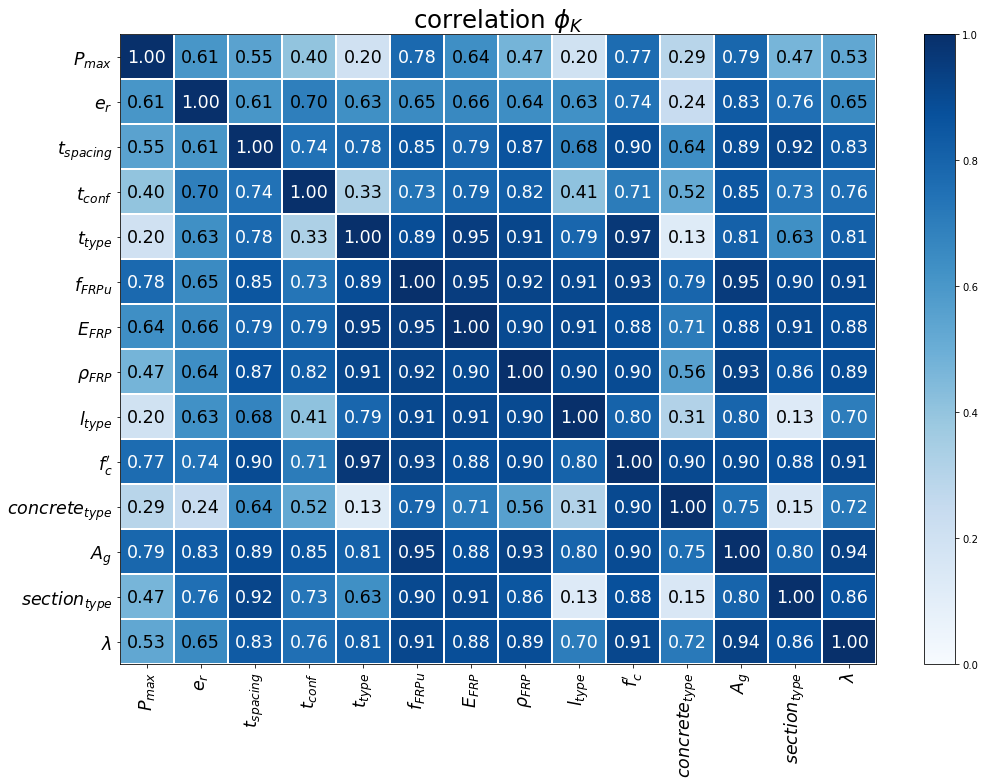

In [14]:
plot_correlation_matrix(phik_overview.values, x_labels=Sxindex, y_labels=Syindex, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.75,
                        figsize=(15,11))
plt.tight_layout()

In [15]:
significance_overview = Data.significance_matrix(interval_cols=interval_cols, bins = bins)
significance_overview

LamdaC   Circular         Ag    TypeCon        fcp      TypeL  \
LamdaC     26.997988  14.121067  20.827501   7.791041  18.736324   8.428949   
Circular   14.121067  19.184654  14.315829   4.806338  12.297091   3.224325   
Ag         20.827501  14.315829  26.587425   7.587301  19.392116   9.130023   
TypeCon     7.791041   4.806338   7.587301  16.577323  11.627590   1.962607   
fcp        18.736324  12.297091  19.392116  11.627590  28.984046  10.310066   
TypeL       8.428949   3.224325   9.130023   1.962607  10.310066  19.313580   
RhoEf      15.866730  12.606773  17.293819   3.681803  15.442695   9.740609   
EfrpL      18.110637  12.643627  17.882004   6.870820  18.699313  12.901160   
ffuL       17.871321  12.372498  17.738811   8.159132  19.471464  13.058598   
TypeH      11.306022   7.630568  12.777638   2.986514  12.900104  15.737741   
Config     13.124917  18.160854  13.384083   5.040241  11.350533   2.942969   
SpacPitch  14.701522  12.843328  18.459996   5.897212  14.201938   6.645368   
EoverD      9.083349   9.488861  11.584707   1.711869  10.009073   3.982949   
Pexp        7.296097   5.016762   9.607860   2.580296   9.501873   1.339145   

               RhoEf      EfrpL       ffuL      TypeH     Config  SpacPitch  \
LamdaC     15.866730  18.110637  17.871321  11.306022  13.124917  14.701522   
Circular   12.606773  12.643627  12.372498   7.630568  18.160854  12.843328   
Ag         17.293819  17.882004  17.738811  12.777638  13.384083  18.459996   
TypeCon     3.681803   6.870820   8.159132   2.986514   5.040241   5.897212   
fcp        15.442695  18.699313  19.471464  12.900104  11.350533  14.201938   
TypeL       9.740609  12.901160  13.058598  15.737741   2.942969   6.645368   
RhoEf      26.430963  16.111955  17.019802  12.641165  11.499152  13.570012   
EfrpL      16.111955  29.153699  21.354670  13.997649  11.136732  12.805323   
ffuL       17.019802  21.354670  26.742354  12.642825  10.531800  13.034402   
TypeH      12.641165  13.997649  12.642825  20.398096   7.249784   8.690035   
Config     11.499152  11.136732  10.531800   7.249784  22.041309  12.354451   
SpacPitch  13.570012  12.805323  13.034402   8.690035  12.354451  25.981166   
EoverD      6.862086   7.363247   7.066310   6.209224   8.480201   7.763566   
Pexp        5.347119   6.519091   7.933679   1.926856   3.913868   3.520229   

              EoverD       Pexp  
LamdaC      9.083349   7.296097  
Circular    9.488861   5.016762  
Ag         11.584707   9.607860  
TypeCon     1.711869   2.580296  
fcp        10.009073   9.501873  
TypeL       3.982949   1.339145  
RhoEf       6.862086   5.347119  
EfrpL       7.363247   6.519091  
ffuL        7.066310   7.933679  
TypeH       6.209224   1.926856  
Config      8.480201   3.913868  
SpacPitch   7.763566   3.520229  
EoverD     26.119314  10.462279  
Pexp       10.462279  28.711989

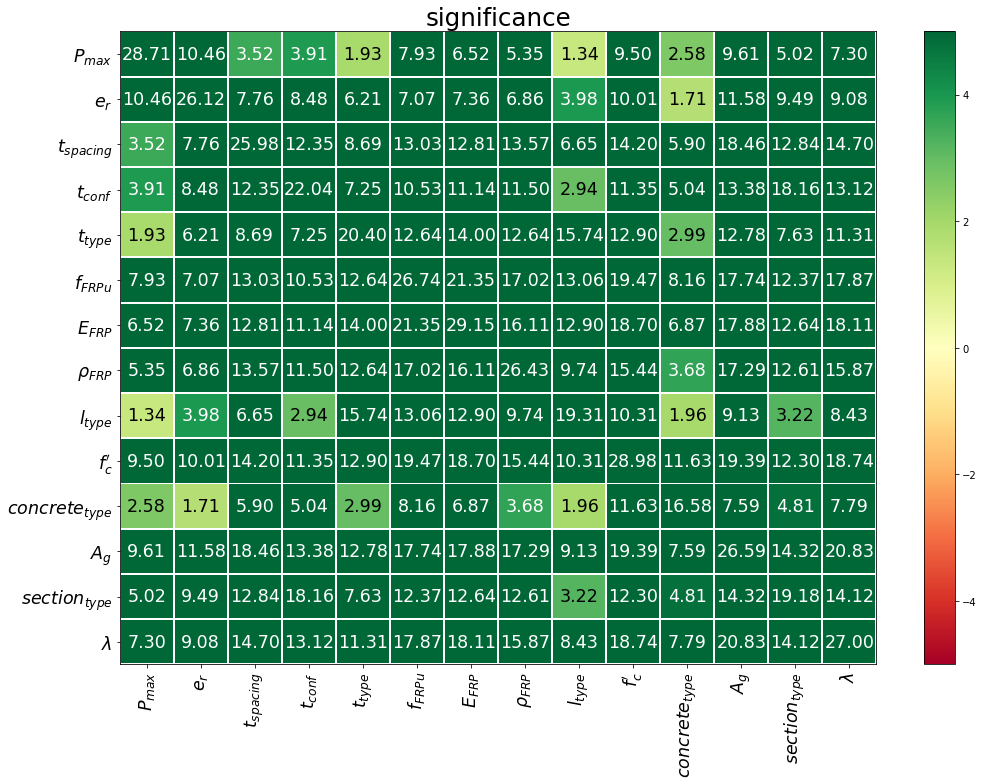

In [16]:
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=Sxindex, 
                        y_labels=Syindex, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.75, figsize=(15,11))


## 3.2 Pairwise Relationships

In [17]:
replacements={'H':r'$H\,(mm)$','LamdaC':r'$\lambda$','Ag': r'$A_g\,(10^{4} mm^{2})$','Circular': r'$section_{type}$','TypeCon': r'$concrete_{type}$','fcp': r'$f^\prime_c\,(MPa)$','TypeL': r'$l_{type}$','RhoEf': r'$\rho_{FRP}\,(\%)$','EfrpL': r'$E_{FRP}\,(GPa)$','ffuL': r'$f_{FRPu}\,(MPa)$','TypeH': r'$t_{type}$','Config': r'$t_{conf.}$','SpacPitch': r'$t_{spacing}\,(mm)$','EoverD': r'$e_{r}\,(\%)$','Pexp': r'$P_{max}\,(kN)$'}


In [18]:
AgData = Data.copy()
AgData['Ag']=AgData['Ag']*1/10000

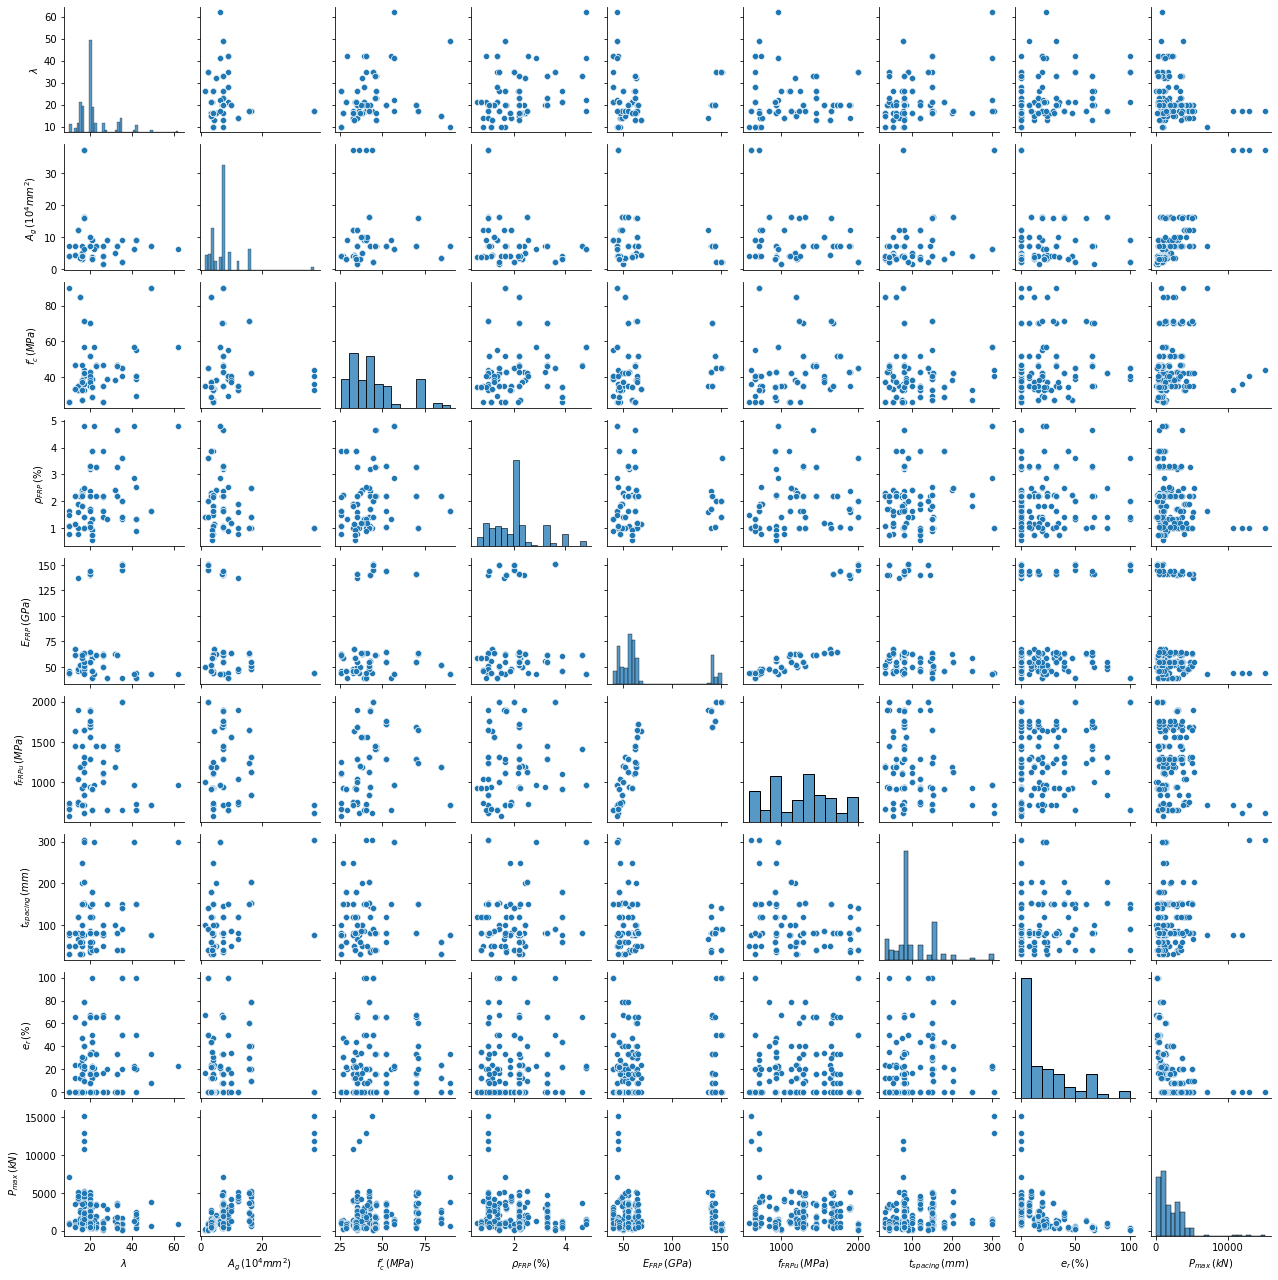

In [19]:
g=sns.pairplot(AgData, diag_kind = 'hist', height=2)


for i in range(9):
    for j in range(9):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

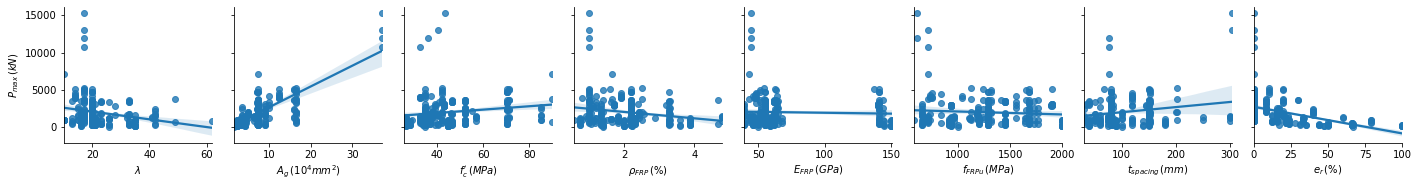

In [20]:
g = sns.pairplot(AgData, height=2.5, 
             x_vars=["LamdaC","Ag","fcp","RhoEf","EfrpL", "ffuL","SpacPitch","EoverD"],y_vars=["Pexp"],kind="reg",diag_kind=None )

for i in range(1):
    for j in range(8):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

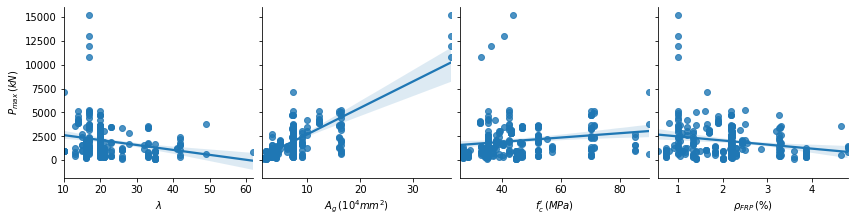

In [21]:
g = sns.pairplot(AgData, height=3, 
             x_vars=["LamdaC","Ag","fcp","RhoEf"],y_vars=["Pexp"],kind="reg",diag_kind=None )

for i in range(1):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

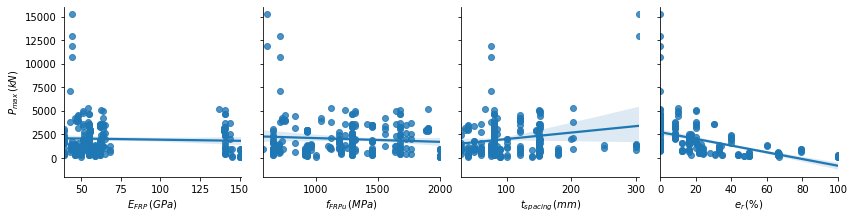

In [22]:
g = sns.pairplot(AgData, height=3, 
             x_vars=["EfrpL", "ffuL","SpacPitch","EoverD"],y_vars=["Pexp"],kind="reg",diag_kind=None )

for i in range(1):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
            
for i in range(len(g.fig.get_children()[-1].texts)):
    label = g.fig.get_children()[-1].texts[i].get_text()
    if label in replacements.keys():
        g.fig.get_children()[-1].texts[i].set_text(replacements[label])

# 4.0 Results in XGBoost with all Data

In [23]:
y = Data['Pexp']
X = Data.drop('Pexp', axis = 1)

X.head()

LamdaC Circular        Ag TypeCon   fcp TypeL  RhoEf  EfrpL   ffuL TypeH  \
0    17.0       No  372100.0     NWC  43.7  GFRP    1.0   44.2  608.0  GFRP   
1    17.0       No  372100.0     NWC  40.6  GFRP    1.0   44.4  712.0  GFRP   
2    17.0       No  372100.0     NWC  36.1  GFRP    1.0   44.2  608.0  GFRP   
3    17.0       No  372100.0     NWC  32.8  GFRP    1.0   44.4  712.0  GFRP   
4    14.0       No  122500.0     NWC  32.6  GFRP    1.9   47.6  728.0  GFRP   

  Config  SpacPitch  EoverD  
0   Ties      305.0     0.0  
1   Ties      305.0     0.0  
2   Ties       76.0     0.0  
3   Ties       76.0     0.0  
4   Ties      120.0     0.0

In [24]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

LamdaC        Ag   fcp  RhoEf  EfrpL   ffuL  SpacPitch  EoverD  \
0    17.0  372100.0  43.7    1.0   44.2  608.0      305.0     0.0   
1    17.0  372100.0  40.6    1.0   44.4  712.0      305.0     0.0   
2    17.0  372100.0  36.1    1.0   44.2  608.0       76.0     0.0   
3    17.0  372100.0  32.8    1.0   44.4  712.0       76.0     0.0   
4    14.0  122500.0  32.6    1.9   47.6  728.0      120.0     0.0   

   Circular_Yes  TypeCon_LWC  TypeCon_NWC  TypeL_CFRP  TypeL_GFRP  TypeH_CFRP  \
0             0            0            1           0           1           0   
1             0            0            1           0           1           0   
2             0            0            1           0           1           0   
3             0            0            1           0           1           0   
4             0            0            1           0           1           0   

   TypeH_GFRP  TypeH_Steel  Config_Spiral  Config_Ties  
0           1            0              0            1  
1           1            0              0            1  
2           1            0              0            1  
3           1            0              0            1  
4           1            0              0            1

In [25]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [26]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 177.760619
MAE: 104.010103
MAPE: 0.069501
R2: 0.983803


# 5.0 Results in XGBoost with input feature according to the existing models

In [27]:
y = DataCode['Pexp']
X = DataCode.drop('Pexp', axis = 1)

X.head()

Circular        Ag   fcp  RhoEf  EfrpL   ffuL
0       No  372100.0  43.7    1.0   44.2  608.0
1       No  372100.0  40.6    1.0   44.4  712.0
2       No  372100.0  36.1    1.0   44.2  608.0
3       No  372100.0  32.8    1.0   44.4  712.0
4       No  122500.0  32.6    1.9   47.6  728.0

In [28]:
X_encoded = pd.get_dummies(X, columns=['Circular'], drop_first=True )
X_encoded.head()

Ag   fcp  RhoEf  EfrpL   ffuL  Circular_Yes
0  372100.0  43.7    1.0   44.2  608.0             0
1  372100.0  40.6    1.0   44.4  712.0             0
2  372100.0  36.1    1.0   44.2  608.0             0
3  372100.0  32.8    1.0   44.4  712.0             0
4  122500.0  32.6    1.9   47.6  728.0             0

In [29]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [30]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 634.498632
MAE: 357.602075
MAPE: 0.170166
R2: 0.794465


# 6.0 Results in XGBoost without confinement

In [31]:
y = DataNoConfin['Pexp']
X = DataNoConfin.drop('Pexp', axis = 1)

X.head()

LamdaC Circular        Ag TypeCon   fcp TypeL  RhoEf  EfrpL   ffuL  EoverD
0    17.0       No  372100.0     NWC  43.7  GFRP    1.0   44.2  608.0     0.0
1    17.0       No  372100.0     NWC  40.6  GFRP    1.0   44.4  712.0     0.0
2    17.0       No  372100.0     NWC  36.1  GFRP    1.0   44.2  608.0     0.0
3    17.0       No  372100.0     NWC  32.8  GFRP    1.0   44.4  712.0     0.0
4    14.0       No  122500.0     NWC  32.6  GFRP    1.9   47.6  728.0     0.0

In [33]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL'], drop_first=True )
X_encoded.head()

LamdaC        Ag   fcp  RhoEf  EfrpL   ffuL  EoverD  Circular_Yes  \
0    17.0  372100.0  43.7    1.0   44.2  608.0     0.0             0   
1    17.0  372100.0  40.6    1.0   44.4  712.0     0.0             0   
2    17.0  372100.0  36.1    1.0   44.2  608.0     0.0             0   
3    17.0  372100.0  32.8    1.0   44.4  712.0     0.0             0   
4    14.0  122500.0  32.6    1.9   47.6  728.0     0.0             0   

   TypeCon_LWC  TypeCon_NWC  TypeL_CFRP  TypeL_GFRP  
0            0            1           0           1  
1            0            1           0           1  
2            0            1           0           1  
3            0            1           0           1  
4            0            1           0           1

In [34]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [35]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 164.724315
MAE: 105.831029
MAPE: 0.069900
R2: 0.986092


# 7.0 Results in XGBoost with only Concentric Columns

In [36]:
y = DataConcentric['Pexp']
X = DataConcentric.drop('Pexp', axis = 1)

X.head()

LamdaC Circular        Ag TypeCon   fcp TypeL  RhoEf  EfrpL   ffuL TypeH  \
0    17.0       No  372100.0     NWC  43.7  GFRP    1.0   44.2  608.0  GFRP   
1    17.0       No  372100.0     NWC  40.6  GFRP    1.0   44.4  712.0  GFRP   
2    17.0       No  372100.0     NWC  36.1  GFRP    1.0   44.2  608.0  GFRP   
3    17.0       No  372100.0     NWC  32.8  GFRP    1.0   44.4  712.0  GFRP   
4    14.0       No  122500.0     NWC  32.6  GFRP    1.9   47.6  728.0  GFRP   

  Config  SpacPitch  
0   Ties      305.0  
1   Ties      305.0  
2   Ties       76.0  
3   Ties       76.0  
4   Ties      120.0

In [37]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

LamdaC        Ag   fcp  RhoEf  EfrpL   ffuL  SpacPitch  Circular_Yes  \
0    17.0  372100.0  43.7    1.0   44.2  608.0      305.0             0   
1    17.0  372100.0  40.6    1.0   44.4  712.0      305.0             0   
2    17.0  372100.0  36.1    1.0   44.2  608.0       76.0             0   
3    17.0  372100.0  32.8    1.0   44.4  712.0       76.0             0   
4    14.0  122500.0  32.6    1.9   47.6  728.0      120.0             0   

   TypeCon_LWC  TypeCon_NWC  TypeL_CFRP  TypeL_GFRP  TypeH_CFRP  TypeH_GFRP  \
0            0            1           0           1           0           1   
1            0            1           0           1           0           1   
2            0            1           0           1           0           1   
3            0            1           0           1           0           1   
4            0            1           0           1           0           1   

   TypeH_Steel  Config_Spiral  Config_Ties  
0            0              0            1  
1            0              0            1  
2            0              0            1  
3            0              0            1  
4            0              0            1

In [38]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [40]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 723.596101
MAE: 288.056805
MAPE: 0.059261
R2: 0.937440


# 8.0 Results in XGBoost with only Eccentric Columns

In [42]:
y = DataEccentric['Pexp']
X = DataEccentric.drop('Pexp', axis = 1)

X.head()

LamdaC Circular       Ag TypeCon    fcp TypeL  RhoEf  EfrpL    ffuL  \
45    26.0       No  14400.0      GC  34.90  BFRP   1.40   50.0  1000.0   
46    26.0       No  14400.0      GC  34.90  BFRP   1.40   50.0  1000.0   
48    49.0      Yes  73062.0     NWC  90.00  GFRP   1.65   43.0   715.0   
49    49.0      Yes  73062.0     NWC  90.00  GFRP   1.65   43.0   715.0   
51    13.0       No  44100.0     NWC  33.15  GFRP   1.15   67.9  1641.0   

    TypeH  Config  SpacPitch  EoverD  
45  Steel    Ties      100.0    67.0  
46  Steel    Ties      100.0    17.0  
48   GFRP  Spiral       76.0     8.0  
49   GFRP  Spiral       76.0    33.0  
51   GFRP    Ties       50.0    12.0

In [43]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

LamdaC       Ag    fcp  RhoEf  EfrpL    ffuL  SpacPitch  EoverD  \
45    26.0  14400.0  34.90   1.40   50.0  1000.0      100.0    67.0   
46    26.0  14400.0  34.90   1.40   50.0  1000.0      100.0    17.0   
48    49.0  73062.0  90.00   1.65   43.0   715.0       76.0     8.0   
49    49.0  73062.0  90.00   1.65   43.0   715.0       76.0    33.0   
51    13.0  44100.0  33.15   1.15   67.9  1641.0       50.0    12.0   

    Circular_Yes  TypeCon_LWC  TypeCon_NWC  TypeL_CFRP  TypeL_GFRP  \
45             0            0            0           0           0   
46             0            0            0           0           0   
48             1            0            1           0           1   
49             1            0            1           0           1   
51             0            0            1           0           1   

    TypeH_CFRP  TypeH_GFRP  TypeH_Steel  Config_Spiral  Config_Ties  
45           0           0            1              0            1  
46           0           0            1              0            1  
48           0           1            0              1            0  
49           0           1            0              1            0  
51           0           1            0              0            1

In [44]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [45]:
xg = xgb.XGBRegressor(random_state=123) 
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))

RMSE: 192.121050
MAE: 130.365674
MAPE: 0.100565
R2: 0.961724


# 9.0 Results in XGBoost with hyperparameter tuning with Random Search and Grid Search for all Data

In [65]:
y = Data['Pexp']
X = Data.drop('Pexp', axis = 1)

X.head()

LamdaC Circular        Ag TypeCon   fcp TypeL  RhoEf  EfrpL   ffuL TypeH  \
0    17.0       No  372100.0     NWC  43.7  GFRP    1.0   44.2  608.0  GFRP   
1    17.0       No  372100.0     NWC  40.6  GFRP    1.0   44.4  712.0  GFRP   
2    17.0       No  372100.0     NWC  36.1  GFRP    1.0   44.2  608.0  GFRP   
3    17.0       No  372100.0     NWC  32.8  GFRP    1.0   44.4  712.0  GFRP   
4    14.0       No  122500.0     NWC  32.6  GFRP    1.9   47.6  728.0  GFRP   

  Config  SpacPitch  EoverD  
0   Ties      305.0     0.0  
1   Ties      305.0     0.0  
2   Ties       76.0     0.0  
3   Ties       76.0     0.0  
4   Ties      120.0     0.0

In [66]:
X_encoded = pd.get_dummies(X, columns=[ 'Circular',
                                        'TypeCon', 
                                        'TypeL',
                                        'TypeH',
                                        'Config'], drop_first=True )
X_encoded.head()

LamdaC        Ag   fcp  RhoEf  EfrpL   ffuL  SpacPitch  EoverD  \
0    17.0  372100.0  43.7    1.0   44.2  608.0      305.0     0.0   
1    17.0  372100.0  40.6    1.0   44.4  712.0      305.0     0.0   
2    17.0  372100.0  36.1    1.0   44.2  608.0       76.0     0.0   
3    17.0  372100.0  32.8    1.0   44.4  712.0       76.0     0.0   
4    14.0  122500.0  32.6    1.9   47.6  728.0      120.0     0.0   

   Circular_Yes  TypeCon_LWC  TypeCon_NWC  TypeL_CFRP  TypeL_GFRP  TypeH_CFRP  \
0             0            0            1           0           1           0   
1             0            0            1           0           1           0   
2             0            0            1           0           1           0   
3             0            0            1           0           1           0   
4             0            0            1           0           1           0   

   TypeH_GFRP  TypeH_Steel  Config_Spiral  Config_Ties  
0           1            0              0            1  
1           1            0              0            1  
2           1            0              0            1  
3           1            0              0            1  
4           1            0              0            1

In [67]:
X_train, X_test, y_train, y_test =  model_selection.train_test_split(
       X_encoded, y, test_size=0.2, random_state=123)

In [68]:
model_xgb = xgb.XGBRegressor(n_estimators =100,
                            max_depth=10,
                             #colsample_bytree= 0.95,
                            alpha=1,
                            subsample=0.90,
                            learning_rate=0.1,
                            random_state=123)

In [69]:
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
mae = mean_absolute_error(y_test,preds)
mape = mean_absolute_percentage_error(y_test, preds)
err = r2_score(y_test,preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))
print("R2: %f" % (err))


RMSE: 162.008743
MAE: 105.426189
MAPE: 0.064889
R2: 0.986546


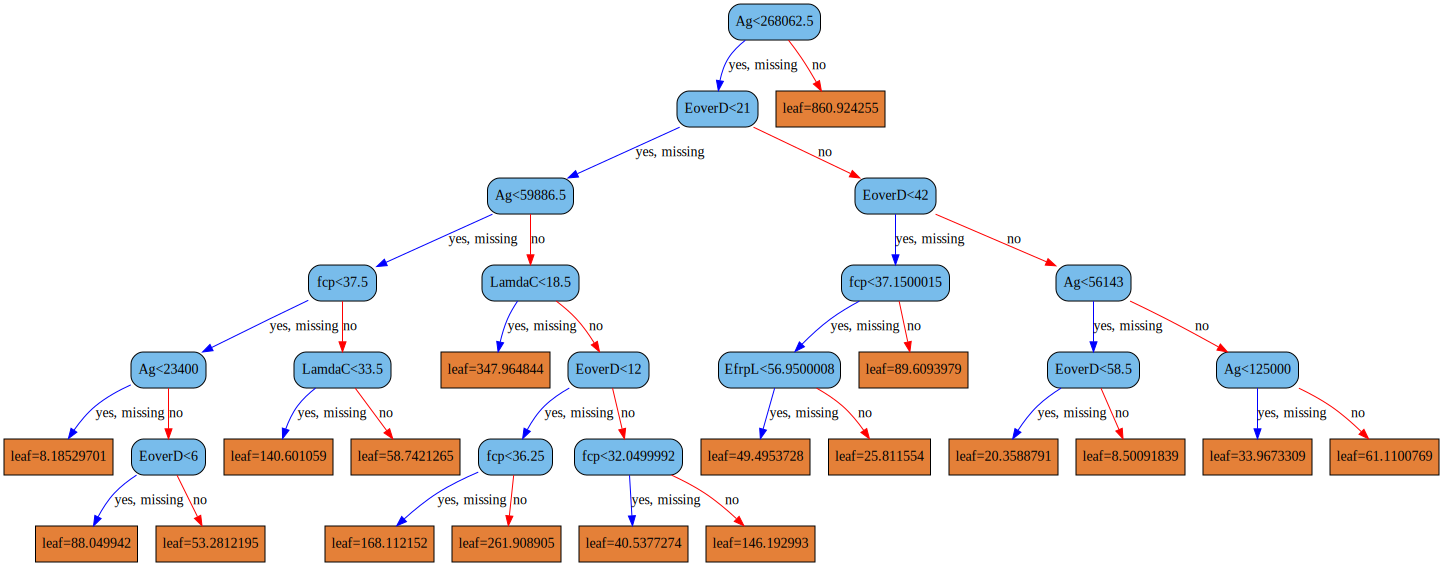

In [70]:
tr= xgb.to_graphviz(model_xgb, num_trees=2, condition_node_params={'shape': 'box',
 'style': 'filled,rounded', 'fillcolor': '#78bceb'},leaf_node_params={'shape': 'box',
 'style': 'filled',
 'fillcolor': '#e48038'})
tr

# 10.0 Interpretation of XGBoost prediction model using SHAP values

In [71]:
featureName=[r'$\lambda$',r'$A_g$', r'$f^\prime_c$', r'$\rho_{FRP}$', r'$E_{FRP}$',r'$f_{FRPu}$',r'$t_{spacing}$',r'$e_{r}$',
           r'$section_{type = circular}$',  r'$concrete_{type = LWC}$',r'$concrete_{type = NWC}$', r'$l_{type = CFRP}$',
          r'$l_{type = GFRP}$',r'$t_{type = CFRP}$',r'$t_{type = GFRP}$',r'$t_{type = steel}$',r'$t_{conf. = spiral}$',
          r'$t_{conf. = ties}$']

In [72]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (15, 4)
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman" # ou serif


#import xgboost
#import shap
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
#model = xgb.train({"learning_rate": 0.2}, xgb.DMatrix(X_encoded, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_encoded)



## 10.1 SHAP summary plot

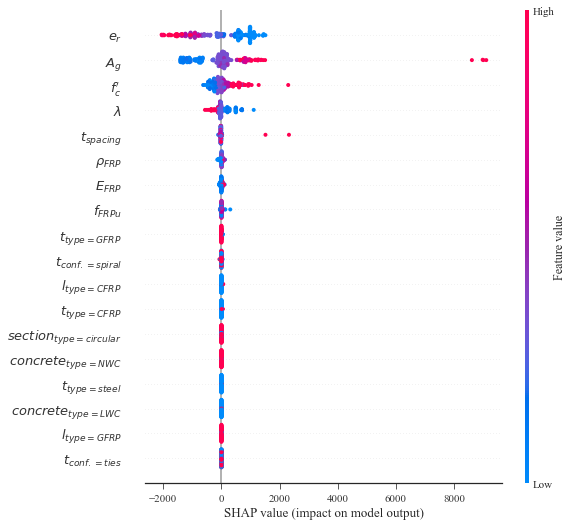

In [73]:
# summarize the effects of all the features
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 20
plt.rcParams["font.family"] = "Times New Roman" 
shap.summary_plot(shap_values, X_encoded, feature_names= featureName,show=False)

## 10.2 Relative importance for each feature

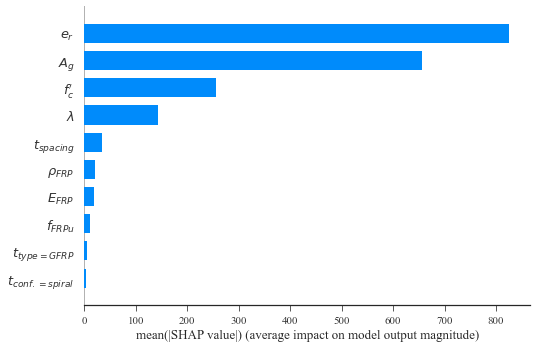

In [74]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman" 
shap.summary_plot(shap_values, X_encoded, plot_type="bar",feature_names=featureName, max_display=10,show=False)

## 10.3 Explanation of typical individual prediction for specimens 

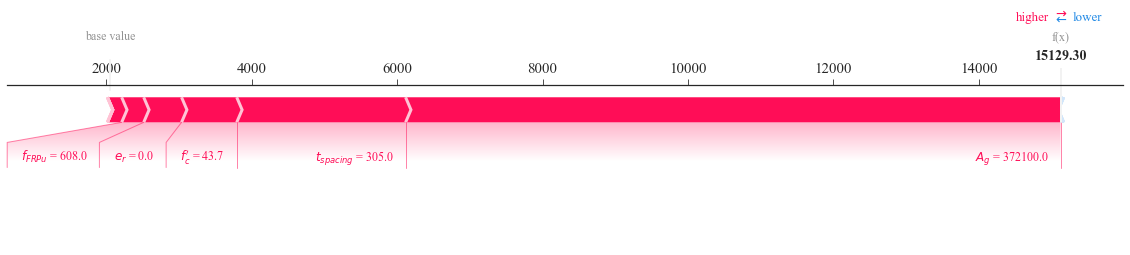

In [75]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
force=shap.force_plot(explainer.expected_value, shap_values[0,:], X_encoded.iloc[0,:], feature_names=featureName, matplotlib = True,show=False) 


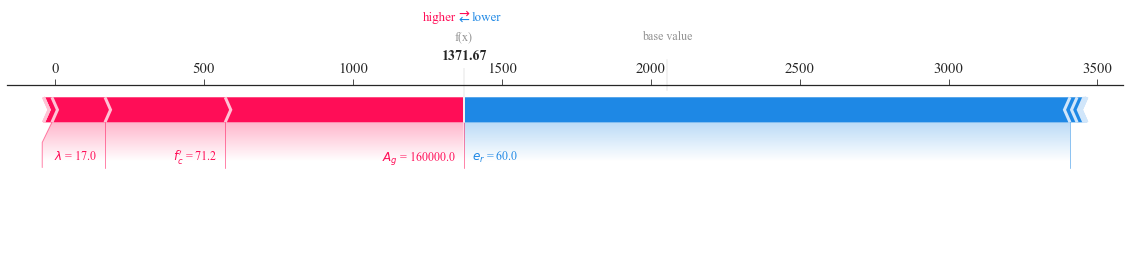

In [76]:
force=shap.force_plot(explainer.expected_value, shap_values[156,:], X_encoded.iloc[156,:], feature_names=featureName, matplotlib = True,show=False) 

## 10.4 SHAP Dependence Plots


In [77]:
featureName=[r'$\lambda$',r'$A_g\,(mm^{2})$', r'$f^\prime_c\,(MPa)$', r'$\rho_{FRP}\,(\%)$', r'$E_{FRP}\,(GPa)$',r'$f_{FRPu}\,(MPa)$',r'$t_{spacing}\,(mm)$',r'$e_{r}\,(\%)$',
           r'$section_{type = circular}$',  r'$concrete_{type = LWC}$',r'$concrete_{type = NWC}$', r'$l_{type = CFRP}$',
          r'$l_{type = GFRP}$',r'$t_{type = CFRP}$',r'$t_{type = GFRP}$',r'$t_{type = steel}$',r'$t_{conf. = spiral}$',
          r'$t_{conf. = ties}$']

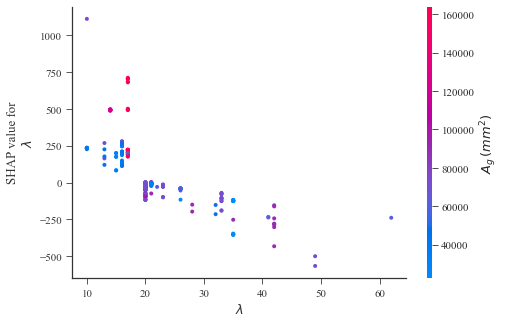

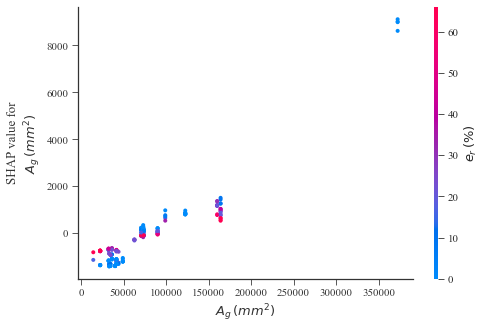

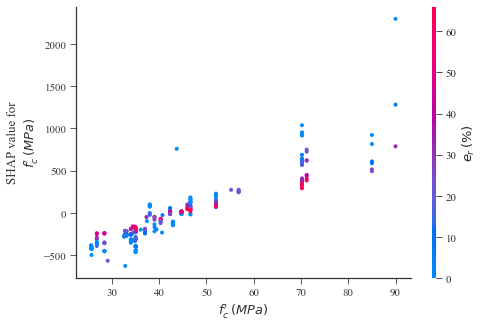

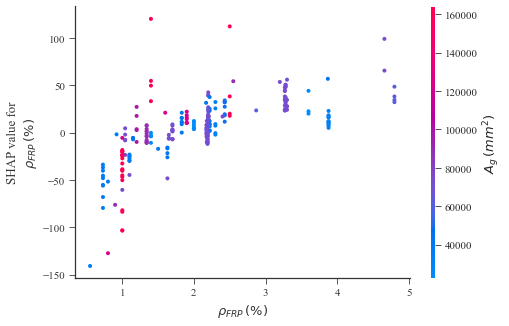

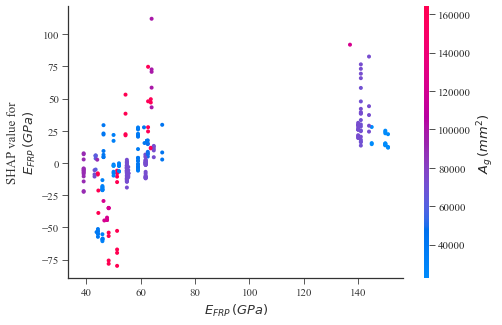

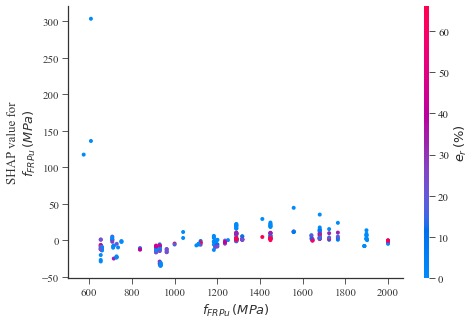

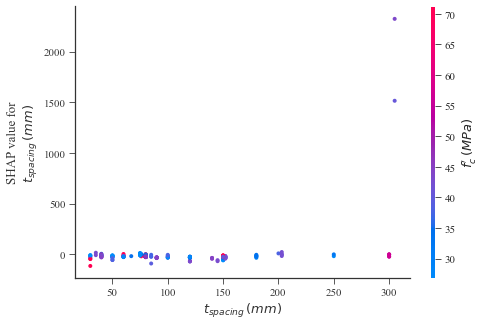

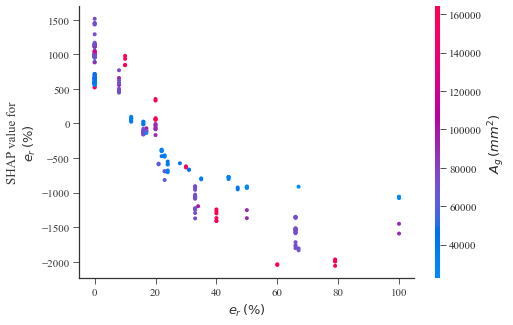

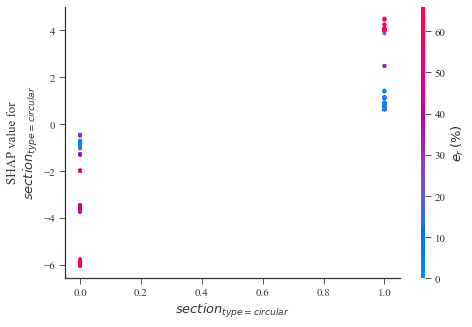

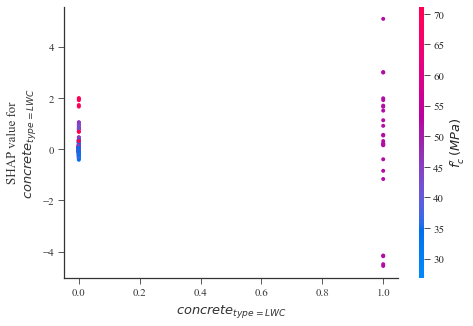

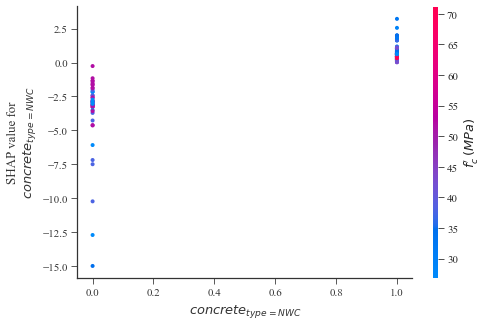

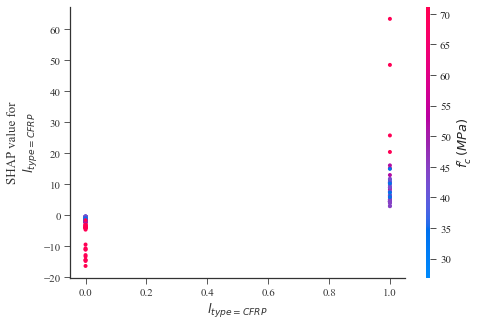

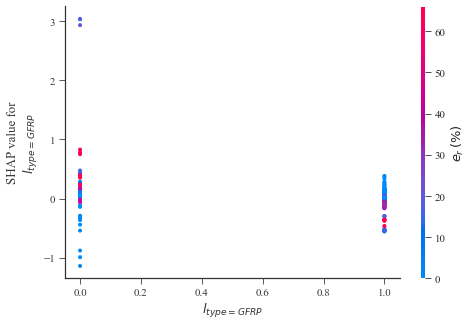

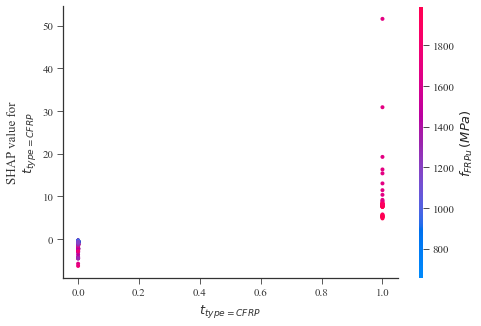

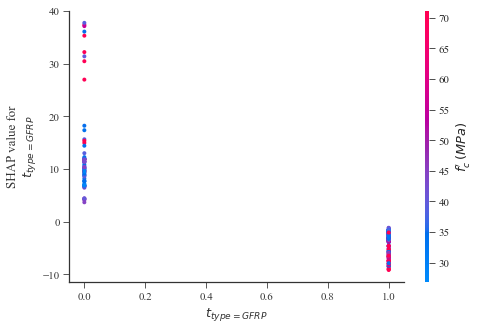

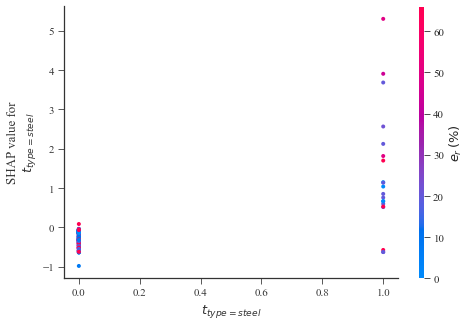

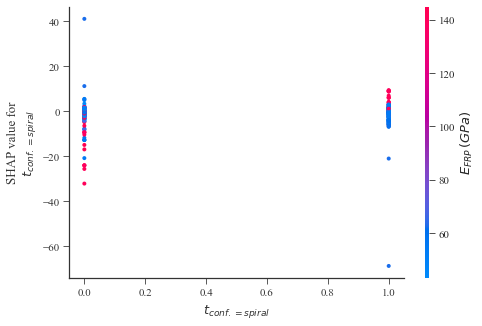

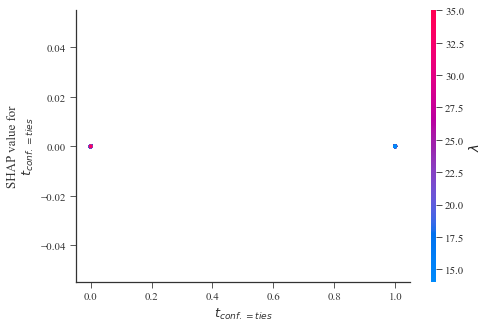

In [78]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman" # ou serif
#fig, ax = plt.subplots(figsize=(8, 5))
length = len(featureName)
for i in range(length):
    name =X_train.columns[i]
    shap.dependence_plot(i, shap_values, X_encoded,feature_names=featureName, show = False)
    plt.show()
